In [1]:
import csv
from zipfile import ZipFile

import numpy as np
from matplotlib import pyplot as plt

from sklearn.exceptions import NotFittedError
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
# plot formatting

plt.rcParams['font.size'] = 10
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 150

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Stochastic Gradient Method

## Part 3 and 4

In [3]:
with ZipFile('nuclear.zip', 'r') as zf:
    
    with zf.open('nuclear_x.csv', 'r') as f:
        X = np.loadtxt(f, delimiter=',')
        
    with zf.open('nuclear_y.csv', 'r') as f:
        y = np.loadtxt(f, delimiter=',', dtype=int)

In [4]:
def batch_hinge_subgradient(X, y, w, b):
    
    hinge_mask = (((X @ w + b) * y) <= 1)
    
    dw = -(y[hinge_mask, None] * X[hinge_mask, :]).sum(0)
    db = -y[hinge_mask].sum()
    
    return dw, db

def run_stochastic_sgm(X, y, step_size, batch_size=1, lamda=0.001, n_iter=100):
    
    n, d = X.shape
    w = np.zeros(d)
    b = 0
    
    ws = [w.copy()]
    bs = [b]
    
    for j in range(1, n_iter + 1):
        
        alpha = step_size(j)
        perm = np.random.permutation(n)
        
        for k in range(0, n, batch_size):
            
            indices = perm[k*batch_size:(k+1)*batch_size]
            
            dw, db = batch_hinge_subgradient(X[indices, :], y[indices], w, b)
            dw += lamda * w * len(indices)
            dw /= n
            db /= n
            
            w -= alpha * dw
            b -= alpha * db
            ws.append(w.copy())
            bs.append(b)
    
    return ws, bs

step_size = lambda j: 100 / j
batch_size = X.shape[0]
lamda = 0.001
n_iter = 50

ws, bs = run_stochastic_sgm(X, y, step_size, batch_size=batch_size, lamda=lamda, n_iter=n_iter)
ws_sto, bs_sto = run_stochastic_sgm(X, y, step_size, batch_size=1, lamda=lamda, n_iter=n_iter)

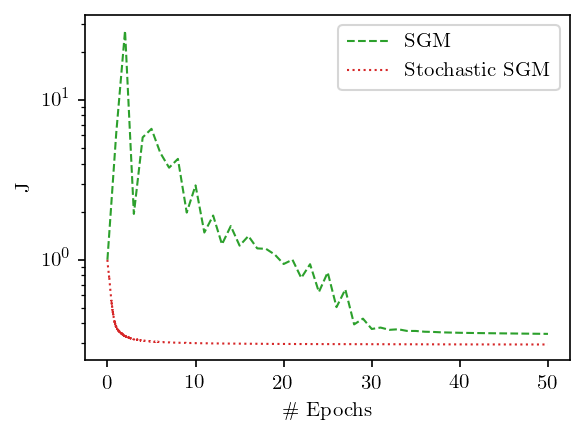

In [5]:
def compute_Js(X, y, ws, bs, lamda):
    
    Js = []
    for w, b in zip(ws, bs):
        
        ts = X @ w + b
        hinges = np.maximum(1 - ts * y, 0)
        Js.append(hinges.mean() + lamda / 2 * np.linalg.norm(w) ** 2)
    
    return Js

Js = compute_Js(X, y, ws, bs, lamda)
# only evaluate J every 100 iterations for stochastic SGM since it is expensive
sto_spacing = 100
Js_sto = compute_Js(X, y, ws_sto[::sto_spacing], bs_sto[::sto_spacing], lamda)

plt.plot(np.arange(len(Js)), Js, '--', color=colors[2], label='SGM')
plt.plot(np.arange(len(Js_sto)) / X.shape[0] * sto_spacing, Js_sto, ':', color=colors[3], label='Stochastic SGM')

plt.yscale('log')

plt.ylabel('J')
plt.xlabel('\# Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
print('SGM:')
print('w0: %g, w1: %g,' % tuple(ws[-1]), 'b: %g,' % bs[-1], 'J: %g' % Js[-1])
print('Stochastic SGM:')
print('w0: %g, w1: %g,' % tuple(ws_sto[-1]), 'b: %g,' % bs_sto[-1], 'J: %g' % Js_sto[-1])

SGM:
w0: -3.67022, w1: 18.1208, b: -1.04168, J: 0.344112
Stochastic SGM:
w0: -2.22854, w1: 11.3857, b: -0.944708, J: 0.29533


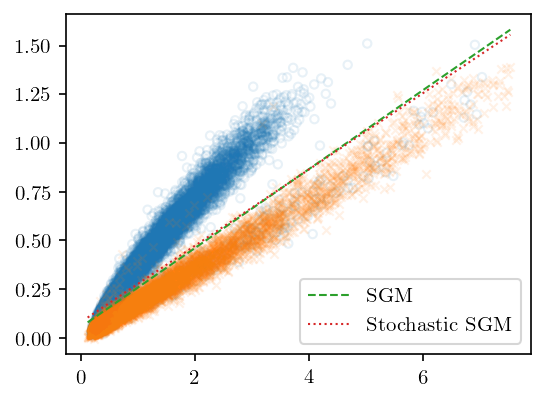

In [7]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', facecolors='none', edgecolors=colors[0], alpha=0.1)
plt.scatter(X[y == -1, 0], X[y == -1, 1], marker='x', facecolors=colors[1], alpha=0.1)

def plot_linear_decision_boundary(w, b, x_min, x_max, pattern, color, label):
    plt.plot([x_min, x_max], [-x_min*w[0]/w[1] - b/w[1], -x_max*w[0]/w[1] - b/w[1]], pattern, color=color, label=label)
    
x_min, x_max = X[:, 0].min(), X[:, 0].max()
plot_linear_decision_boundary(ws[-1], bs[-1], x_min, x_max, '--', colors[2], 'SGM')
plot_linear_decision_boundary(ws_sto[-1], bs_sto[-1], x_min, x_max, ':', colors[3], 'Stochastic SGM')

plt.legend()
plt.show()